# Produces Figure 9

In [10]:
%load_ext autoreload
%autoreload 2
from scapy.contrib.modbus import *
from scapy.contrib.stun import *
from scapy.layers.usb import *
from PY.scapy_tools import get_packet_class_by_name, pkt2field_names_bytes, get_packet_instance_by_name

from scapy.all import *
import matplotlib
from matplotlib.patches import Rectangle
from matplotlib.backends.backend_pgf import FigureCanvasPgf
matplotlib.backend_bases.register_backend('pdf', FigureCanvasPgf)
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'text.latex.preamble': '\\usepackage[dvips]{graphicx}\\usepackage{xfrac}\\usepackage{amssymb}\\usepackage{lmodern}'
})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
STATIC_KEYS = ['ARP', 'ModBusTCP', 'UDP', 'PPPoED', 'EAPOL', 'SCTP', 'VRRP', 'NBNSHeader']
PARENTS = [Ether, TCP, IP, Ether, Ether, IP, IP, UDP]
valid_fields = ['StrField', 'Field', 'ByteField', 'ByteEnumField', 'StrLenField', 'FlagsField', 'StrFixedLenField', 'PadField', 
                    'SockAddrsField', 'LenField', 'EnumField', 'FieldLenField', 'MayEnd', 'XStrLenField', 'IP6Field', 'UUIDField', 'ShortField', 'XByteField', 'XShortField', 
                    'BitField', 'BitEnumField', 'MACField', 'FieldListField', 'XIntField', 'IntField', 'LongField', 'IntEnumField', 'SignedIntField', 
                    'XNBytesField', 'XBitField', 'ShortEnumField', 'XShortEnumField', 'SourceMACField', 'SourceIPField', 'IPField']

# Real Data Distribution

In [12]:
from PY.build_X_y import build_real_x_y, build_fake_x_y
from PacketDataset import PacketDataset
from torch.utils.data import Dataset, DataLoader
from Plotting import plot_protocol_distribution

XR, yR, psR = build_real_x_y(STATIC_KEYS, PARENTS)
dataset = PacketDataset(XR, yR, protocols=psR, pkt_len=32)
tloader = DataLoader(dataset, batch_size=1, shuffle=True)
p_count_dict = {p:3 for p in STATIC_KEYS}

ModuleNotFoundError: No module named 'torch'

# Plot example of generated packets

In [ ]:
import numpy as np

def plot_pkt_img(ax, array, cmap):
    masked_arr = np.ma.masked_where(array == -255, array)[:50,:16]
    im = ax.imshow(masked_arr, cmap=cmap, interpolation='none', vmin=0, vmax=255)
    return im

col=3
ARP ARP ARP who has 0.0.0.0 says 0.0.0.0
NUM PARSED 256
ARP ARP ARP who has 0.0.0.0 says 0.0.0.0
NUM PARSED 256
ARP ARP ARP who has 0.0.0.0 says 0.0.0.0
NUM PARSED 256
ModBusTCP ModbusADURequest ModbusADURequest
NUM PARSED 256
ModBusTCP ModbusADURequest ModbusADURequest
NUM PARSED 256
ModBusTCP ModbusADURequest ModbusADURequest
NUM PARSED 256
UDP UDP UDP domain > domain
NUM PARSED 256
UDP UDP UDP domain > domain
NUM PARSED 256
UDP UDP UDP domain > domain
NUM PARSED 256
PPPoED PPPoED PPPoE Active Discovery Initiation (PADI)
NUM PARSED 256
PPPoED PPPoED PPPoE Active Discovery Initiation (PADI)
NUM PARSED 256
PPPoED PPPoED PPPoE Active Discovery Initiation (PADI)
NUM PARSED 256
EAPOL EAPOL EAPOL EAP-Packet
NUM PARSED 256
EAPOL EAPOL EAPOL EAP-Packet
NUM PARSED 256
EAPOL EAPOL EAPOL EAP-Packet
NUM PARSED 256
SCTP SCTP SCTP
NUM PARSED 256
SCTP SCTP SCTP
NUM PARSED 256
SCTP SCTP SCTP
NUM PARSED 256
VRRP VRRP VRRP
SCAPY TOOLS FAILED Layer [IP] not found ['VRRP'] VRRPv3
SCAPY TOOLS FAILE

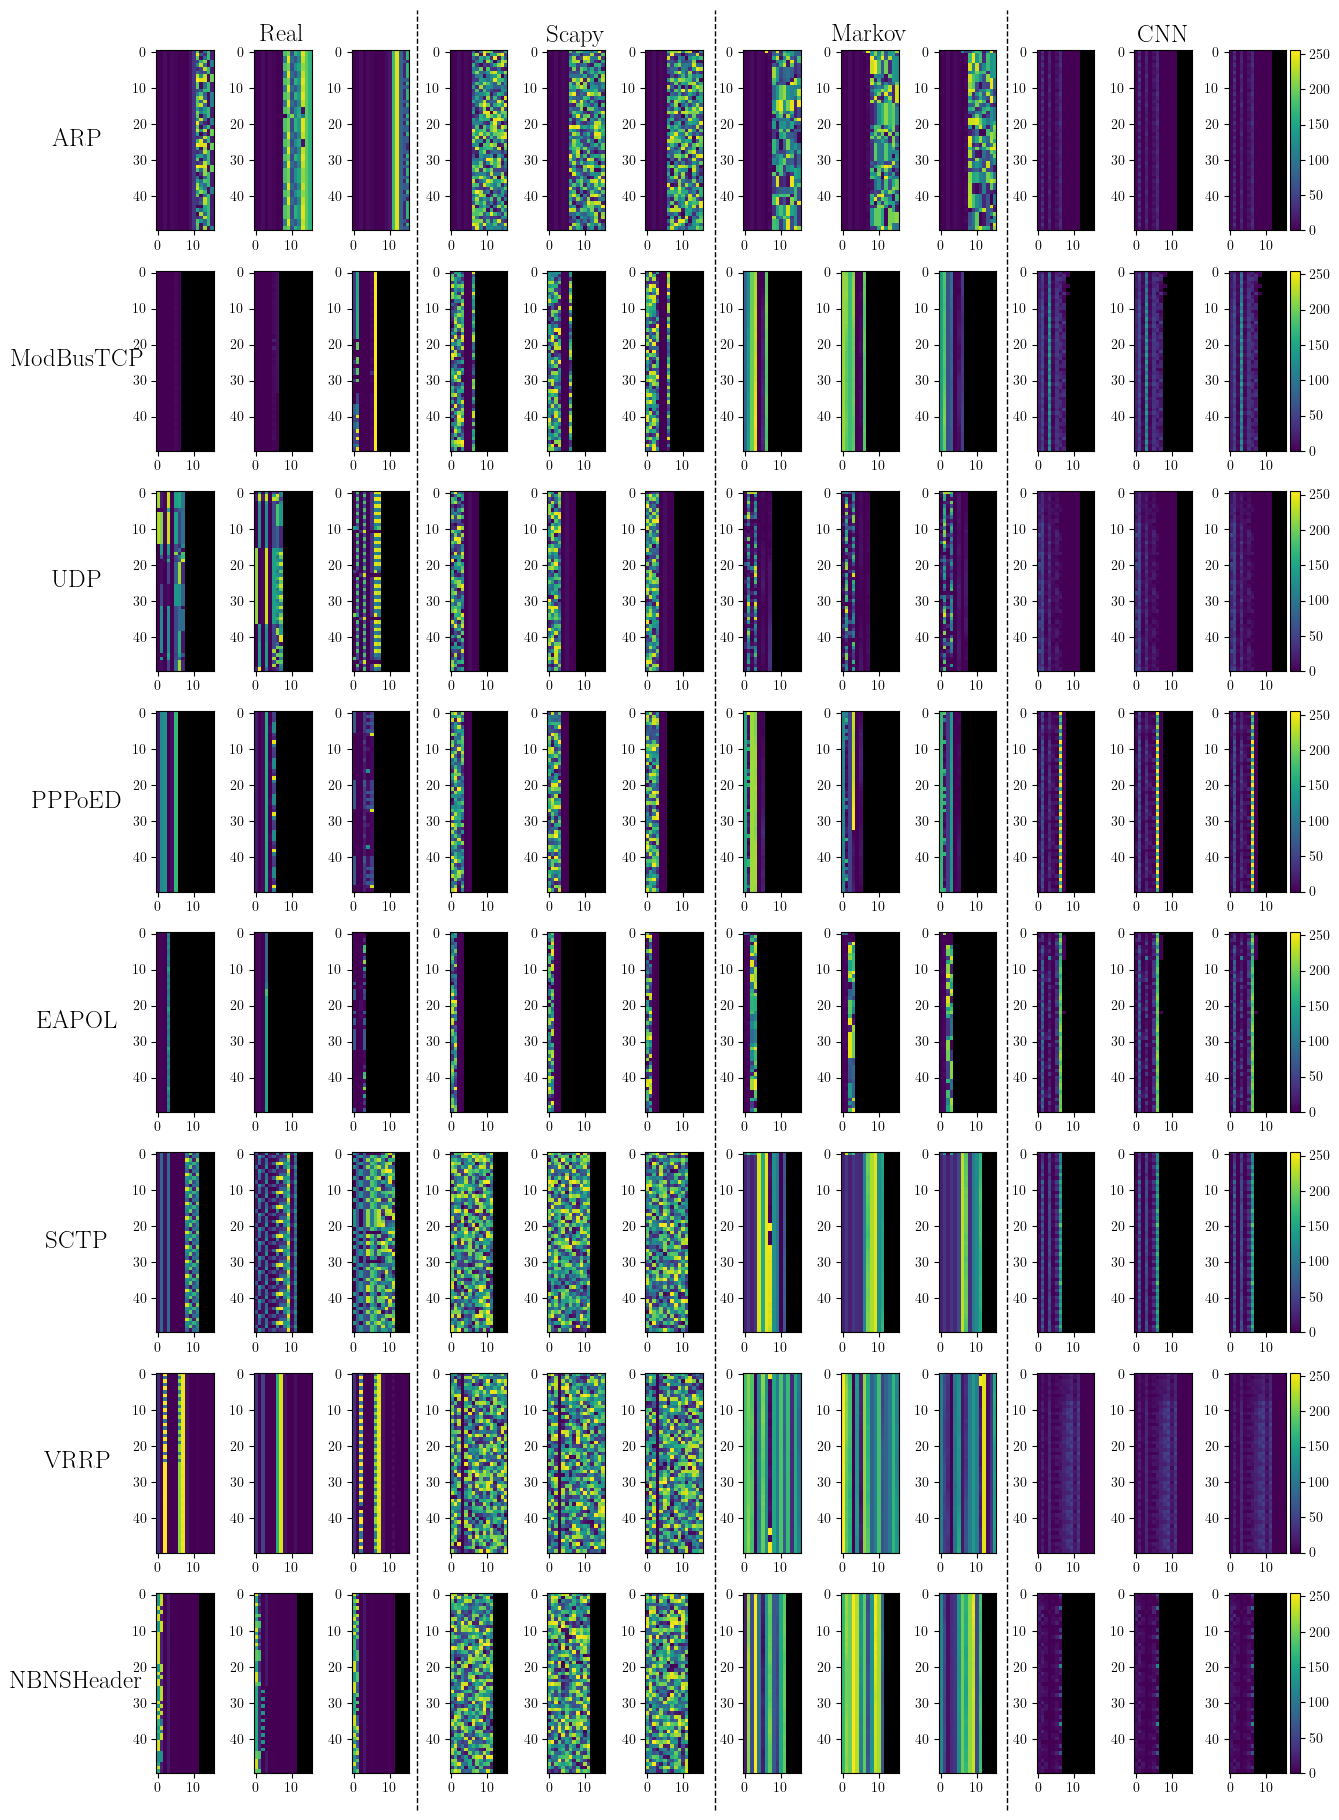

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import colormaps as cm

fig, axes = plt.subplots(nrows=len(STATIC_KEYS), ncols=4*3, figsize=(13.5,18))
# Use perceptually uniform colormap, e.g. 'viridis'
cmap = cm.get_cmap('viridis').copy()
cmap.set_bad(color='black')  # Masked values (-255) appear black

#gen real
for row, p in enumerate(STATIC_KEYS):
    c=0
    for img, _, p1 in tloader:
        if p1[0] == p:
            plot_pkt_img(axes[row,c], img[0], cmap)
            axes[row, 0].set_ylabel(p, fontsize=18, rotation=0, labelpad=40, va='center')
            c+=1
            if c==3:
                break
#for c in range(3):
axes[0,1].set_title("Real", size=18)


for col, gen in enumerate(['Scapy', 'Markov', 'CNN']):
    col = 3 + 3*col
    print(f'{col=}')
    Xf, yf, psf = build_fake_x_y(p_count_dict, STATIC_KEYS, PARENTS, generator=gen, FIELD_TYPE_VOCAB=valid_fields)
    assert len(Xf) == 3*len(STATIC_KEYS)
    dataset = PacketDataset(Xf, yf, protocols=psf)
    loader = DataLoader(dataset, batch_size=1, shuffle=True)
    for row, p in enumerate(STATIC_KEYS):
        c = 0
        for img, _, p1 in loader:
            if p1[0] == p:
                im = plot_pkt_img(axes[row,col+c], img[0], cmap)
                if col+c == 11:
                    fig.colorbar(im, ax=axes[row,col+c])
                c += 1
                if c==3:
                    break
        assert c==3, c
    #for c in range(3):                
    axes[0,col+1].set_title(f"{gen}", size=18)

from matplotlib.lines import Line2D

# Add vertical separators after every 3 columns (i.e., after cols 2, 5, 8)
for sep_col in [3.75, 6.4, 9]:
    x = sep_col / (4*3)  # normalize to [0,1] range of figure width
    line = Line2D([x, x], [0, 1], transform=fig.transFigure,
                  color='black', linewidth=1, linestyle='--')
    fig.lines.append(line)

plt.tight_layout()
plt.savefig('Plots/GeneratedExamples.pdf')

plt.show()